In [1]:
# Import Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
from itertools import cycle
from datetime import datetime, timedelta
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display
from scipy import stats
import pymannkendall as mk

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence, select_months
from eofs import *
from ar_funcs import get_ar_days, duration_stats
from kmeans import *
import nclcmaps as ncl

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# choose parameters
reanalysis = 'era5'
ssn = 'djfmam'
ceofid = 'IVT'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'

# import configuration file for season dictionary choice
yaml_doc = '../data/plt_config.yml'
config1 = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)

ar_dict = config1[ssn]
start_date = ar_dict['start_date']
end_date = ar_dict['end_date']
print(start_date, end_date)

1979-12-01 9:00 2019-05-31 9:00


In [4]:
# load AR CAT
filepath = out_path + 'AR-types_ALLDAYS.csv'
ar_cat = pd.read_csv(filepath)
ar_cat = ar_cat.rename(columns={'Unnamed: 0': 'time'})
ar_cat = ar_cat.set_index(pd.to_datetime(ar_cat['time']))
# ar_cat.index = ar_cat.index.strftime("%Y-%m-%d")
ar_cat = ar_cat.drop(columns=['time'])
# ar_cat = ar_cat.reset_index()
ar_cat

,AR_CAT
time,
1979-12-01 09:00:00,2
1979-12-02 09:00:00,1
1979-12-03 09:00:00,0
1979-12-04 09:00:00,0
1979-12-05 09:00:00,0
...,...
2019-05-27 09:00:00,0
2019-05-28 09:00:00,0
2019-05-29 09:00:00,1


In [6]:
## Separate the AR Types into multiple columns
# create a new df that breaks up the AR_CAT col so each category has its own column
datesALLdays = ar_cat.index.values
keys = []
for k in range(nk):
    keys.append("AR_CAT{:1d}".format(k+1,))

values = np.zeros((len(datesALLdays)))
dicts = dict(zip(keys, values))

df_cat = pd.DataFrame(dicts, index=datesALLdays)
df_cat['AR_ALL'] = values

for k in range(nk):
    idx = (ar_cat['AR_CAT'] == k+1)
    col = "AR_CAT{:1d}".format(k+1,)
    df_cat.loc[idx, col] = 1
    df_cat.loc[idx, 'AR_ALL'] = 1


df_cat

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL
1979-12-01 09:00:00,0.0,1.0,0.0,1.0
1979-12-02 09:00:00,1.0,0.0,0.0,1.0
1979-12-03 09:00:00,0.0,0.0,0.0,0.0
1979-12-04 09:00:00,0.0,0.0,0.0,0.0
1979-12-05 09:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...
2019-05-27 09:00:00,0.0,0.0,0.0,0.0
2019-05-28 09:00:00,0.0,0.0,0.0,0.0
2019-05-29 09:00:00,1.0,0.0,0.0,1.0
2019-05-30 09:00:00,0.0,0.0,0.0,0.0


In [8]:
# resample to seasonal frequency
df_ssn = df_cat.resample('QS-DEC').sum()
# select only DJF and MAM
df_ssn = select_months(df_ssn, 12, 5)
df_ssn

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL
1979-12-01,19.0,11.0,8.0,38.0
1980-03-01,4.0,9.0,21.0,34.0
1980-12-01,8.0,15.0,13.0,36.0
1981-03-01,11.0,14.0,22.0,47.0
1981-12-01,14.0,5.0,14.0,33.0
...,...,...,...,...
2017-03-01,6.0,13.0,23.0,42.0
2017-12-01,6.0,5.0,18.0,29.0
2018-03-01,12.0,14.0,15.0,41.0
2018-12-01,12.0,12.0,20.0,44.0


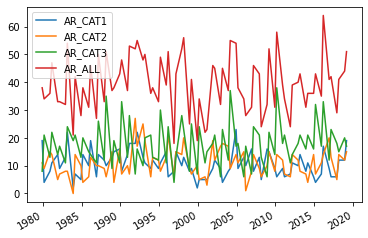

In [9]:
lines = df_ssn.plot.line()

In [12]:
data_lst = ['AR_CAT1', 'AR_CAT2', 'AR_CAT3', 'AR_ALL']
for i, data in enumerate(data_lst):
    print(mk.original_test(df_ssn[data].values))

Mann_Kendall_Test(trend='no trend', h=False, p=0.1588212688706907, z=-1.409047007200642, Tau=-0.10727848101265823, s=-339.0, var_s=57541.666666666664, slope=-0.03252247488101534, intercept=11.284637757800105)
Mann_Kendall_Test(trend='no trend', h=False, p=0.5183001287196802, z=0.6459679240054902, Tau=0.049367088607594936, s=156.0, var_s=57576.0, slope=0.0, intercept=10.5)
Mann_Kendall_Test(trend='no trend', h=False, p=0.4437738123749595, z=0.7658361316306797, Tau=0.058544303797468354, s=185.0, var_s=57725.0, slope=0.02532051282051282, intercept=15.999839743589744)
Mann_Kendall_Test(trend='no trend', h=False, p=0.7020424964925711, z=0.38256476936707917, Tau=0.029430379746835444, s=93.0, var_s=57831.666666666664, slope=0.017879948914431672, intercept=37.79374201787995)


In [13]:
df_yr = df_ssn.resample('1Y').sum()
for i, data in enumerate(data_lst):
    print(mk.original_test(df_yr[data].values))

Mann_Kendall_Test(trend='no trend', h=False, p=0.1906467034197048, z=-1.3086683906166645, Tau=-0.14268292682926828, s=-117.0, var_s=7857.0, slope=-0.09449404761904762, intercept=22.889880952380953)
Mann_Kendall_Test(trend='no trend', h=False, p=0.5358254185658282, z=0.6191380502916255, Tau=0.06829268292682927, s=56.0, var_s=7891.333333333333, slope=0.0625, intercept=20.75)
Mann_Kendall_Test(trend='no trend', h=False, p=0.3984935043101916, z=0.8443148244652351, Tau=0.09268292682926829, s=76.0, var_s=7890.666666666667, slope=0.09090909090909091, intercept=33.18181818181818)
Mann_Kendall_Test(trend='no trend', h=False, p=0.7444343648126583, z=0.32598677008958427, Tau=0.036585365853658534, s=30.0, var_s=7914.0, slope=0.06559139784946236, intercept=75.68817204301075)


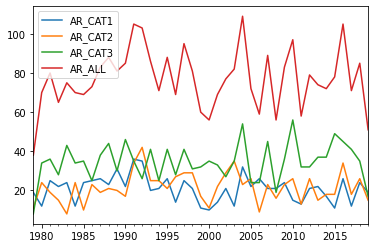

In [14]:
lines = df_yr.plot.line()

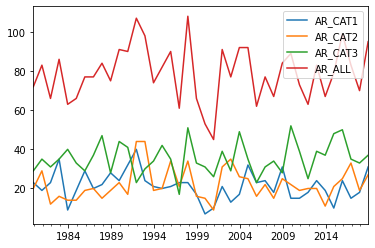

In [18]:
# resample to seasonal frequency
df_test = df_cat.resample('6MS').sum()
df_test = select_months(df_test, 12, 5)
lines = df_test.plot.line()

In [19]:
for i, data in enumerate(data_lst):
    print(mk.original_test(df_test[data].values))

Mann_Kendall_Test(trend='no trend', h=False, p=0.20663848706021004, z=-1.2628628106270983, Tau=-0.13974358974358975, s=-109.0, var_s=7313.666666666667, slope=-0.125, intercept=23.4375)
Mann_Kendall_Test(trend='no trend', h=False, p=0.2377160972668082, z=1.180714656098316, Tau=0.13076923076923078, s=102.0, var_s=7317.333333333333, slope=0.10263157894736842, intercept=17.998684210526317)
Mann_Kendall_Test(trend='no trend', h=False, p=0.3938103208123249, z=0.8527277094885621, Tau=0.09487179487179487, s=74.0, var_s=7328.666666666667, slope=0.10263157894736842, intercept=32.998684210526314)
Mann_Kendall_Test(trend='no trend', h=False, p=0.5834048224838704, z=0.5484181415848901, Tau=0.06153846153846154, s=48.0, var_s=7344.666666666667, slope=0.10101010101010101, intercept=76.03030303030303)


In [26]:
rename_dict = {'AR_CAT1': 'Karakoram ARs', 'AR_CAT2': 'Pamir ARs', 'AR_CAT3': 'E. Himalayan ARs'}
df_tmp = df_cat.drop(columns=['AR_ALL'])
df_tmp = df_tmp.rename(columns = rename_dict, inplace = False)
df_tmp = df_tmp.groupby(df_cat.index.month).sum()
df_tmp.loc[:,"Month"] = df_tmp.index
results = pd.melt(df_tmp, id_vars=['Month'], var_name='subtype', value_name='frequency')
results

,Month,subtype,frequency
0,1,Karakoram ARs,158.0
1,2,Karakoram ARs,157.0
2,3,Karakoram ARs,235.0
3,4,Karakoram ARs,143.0
4,5,Karakoram ARs,60.0
5,12,Karakoram ARs,104.0
6,1,Pamir ARs,139.0
7,2,Pamir ARs,171.0
8,3,Pamir ARs,228.0
9,4,Pamir ARs,126.0


/home/nash/DATA/repositories/AR_types/figs/IVT/djfmam/neof2/k3/ARTYPE_freq_barplot.png


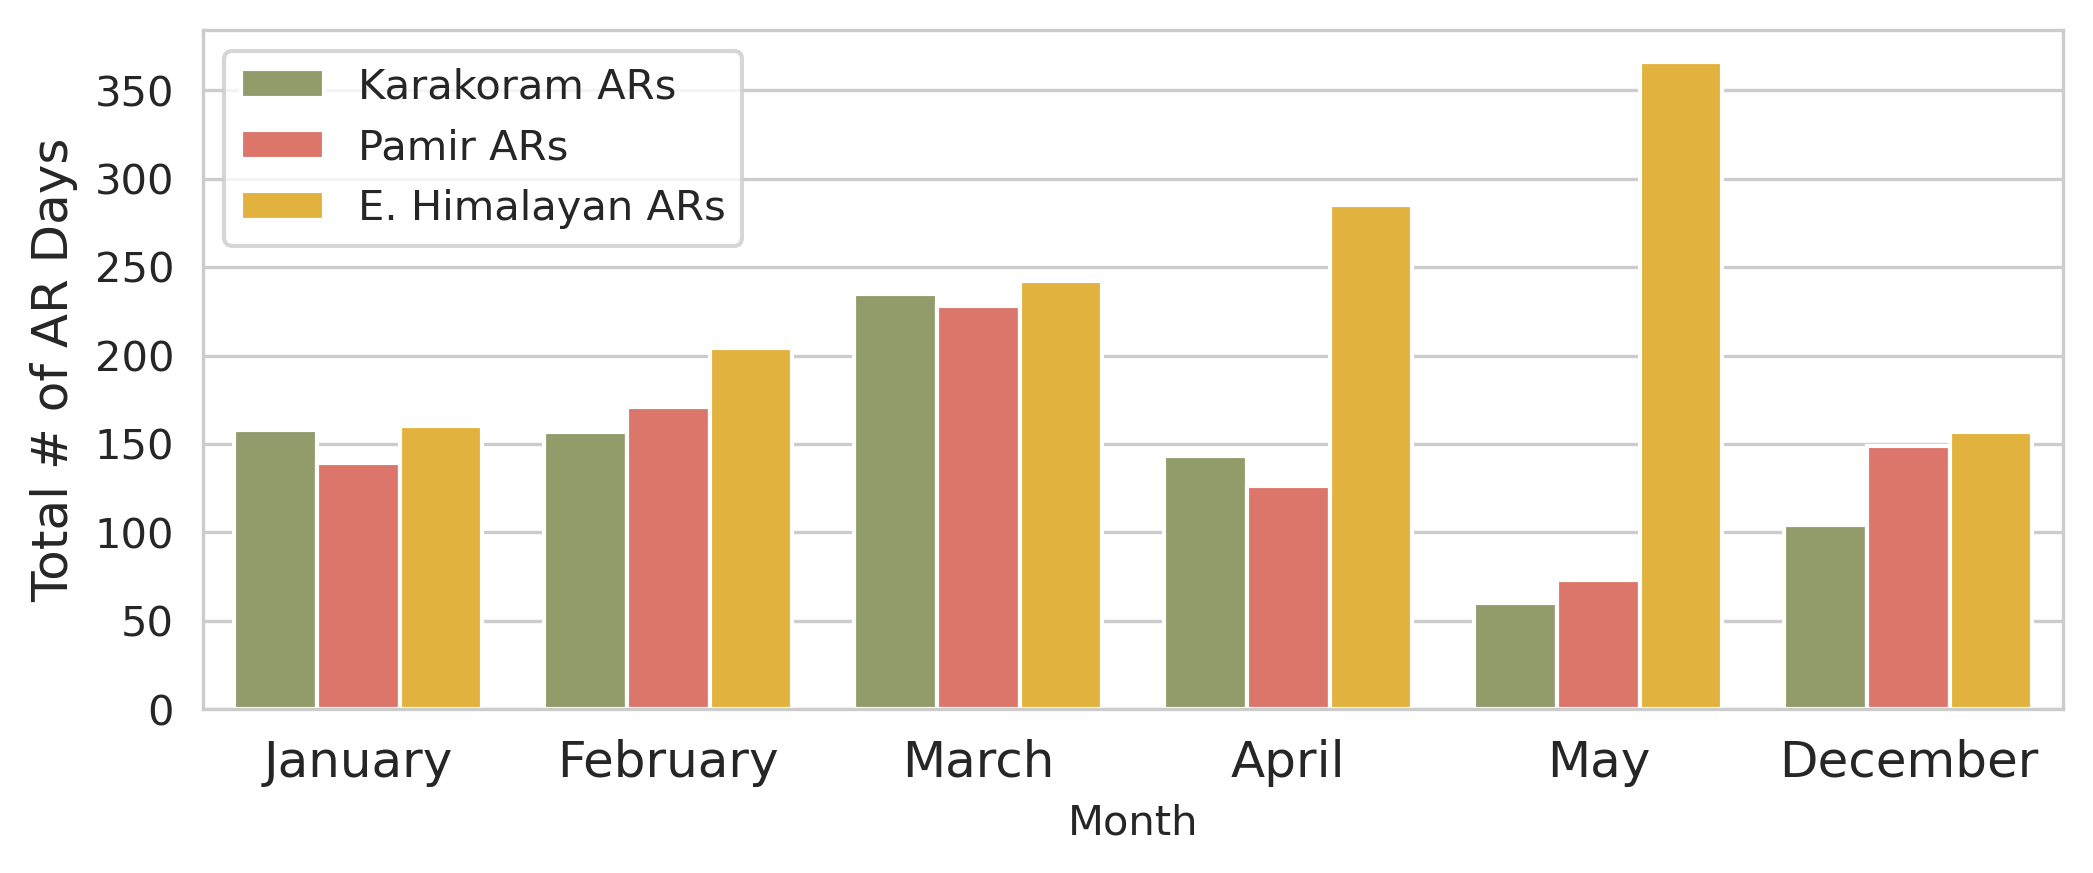

<Figure size 2400x900 with 0 Axes>

In [31]:
fname = fig_path + 'ARTYPE_freq_barplot' 
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((8.0,3.0))
fig.dpi = 300
nplots=1

# Set custom color palette
colors = ['#95a462', '#ef6758', '#fcbd23']
sns.set_palette(sns.color_palette(colors))
columns=['January', 'February', 'March', 'April', 'May', 'December']
          
sns.set_style("whitegrid")
# sns.set_context("paper")
sns.despine()

for i in np.arange(nplots):
    ax = fig.add_subplot(1, 1, i+1)
    g = sns.barplot(x='Month', y='frequency', hue='subtype', data=results)
    ax.set_ylabel('Total # of AR Days', fontsize=12)
    ax.set_xticklabels(columns, fontsize=12)
    ax.legend(loc='upper left')
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))